# Molecular Isotopic Distributions Part 1: Enumerating Isotopic Placements

Elements can have several [isotopes](https://en.wikipedia.org/wiki/Isotope), which have the same number of protons and neutrons but different numbers of neutrons. Because a neutron has a mass of approximately 1 amu (atomic mass unit), different isotopes of an element appear at different masses in a mass spectrum as measured by a mass spectrometer.

Different elements have different isotopes and different natural abundances, meaning the percent of each isotope that is found in nature. For example, [carbon has two stable isotopes](https://en.wikipedia.org/wiki/Isotopes_of_carbon), <sup>12</sup>C with 98.9% natural abundance and <sup>13</sup>C with 1.06% natural abundance. As another example, [oxygen has three stable isotopes](https://en.wikipedia.org/wiki/Isotopes_of_oxygen), <sup>16</sup>O with 99.8% natural abundance, <sup>17</sup>O with 0.0380% natural abundance, and <sup>18</sup>O with 0.205% natural abundance. The distribution of isotopes thus forms a fingerprint for an element. As another example, [chlorine has two stable isotopes with significant natural abundance](https://en.wikipedia.org/wiki/Isotopes_of_chlorine), <sup>35</sup>Cl with 76% natural abundance, and <sup>37</sup>O with 24% natural abundance. The distribution of isotopes thus forms a fingerprint for an element. 

When atoms combine into molecules, the mass distributions get richer. For example, in the diatomic molecule chlorine Cl<sub>2</sub>, which has two chlorine atoms, there are three possible molecular isotopes:

In [76]:
# !pip install rdkit
# !pip install mendeleev

In [230]:
from collections import defaultdict
import hashlib
import json

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl

import mendeleev
from rdkit import Chem
from rdkit.Chem import Descriptors

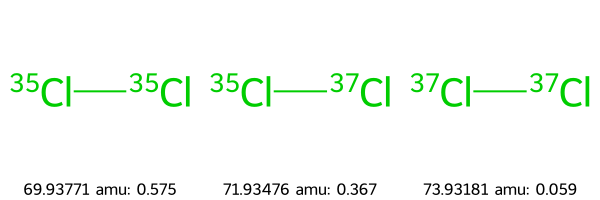

In [120]:
chlorine_smls = ["[35Cl][35Cl]", "[35Cl][37Cl]", "[37Cl][37Cl]"]
chlorine_mols = [Chem.MolFromSmiles(sml) for sml in chlorine_smls]
chlorine_masses = [Descriptors.ExactMolWt(mol) for mol in chlorine_mols]
chlorine_abundances = [0.574564, 0.366872, 0.058564]
legends = [f"{mass:.5f} amu: {abundance:.3f}" for mass, abundance in zip(chlorine_masses, chlorine_abundances)]
legends
Chem.Draw.MolsToGridImage(chlorine_mols, legends=legends)

The molecule <sup>35</sup>Cl<sup>37</sup>Cl in the middle, with mixed isotopes, represents two possible placements of the isotopes: it is equivalent to <sup>37</sup>Cl<sup>35</sup>Cl because the order of the chlorine atoms is not significant due to symmetry. The code to generate such molecules, masses, abundance, and images will be given in this blog post and the next.

In part 1, I use the naive method of creating a molecule for each possible arrangement of isotopes ([permutation](https://en.wikipedia.org/wiki/Permutation)) of a molecule. I hazily recalled that I could
- enumerate the [combinations](https://en.wikipedia.org/wiki/Combination), where the order of the isotopes over the atoms in a molecule is disregarded, and 
- calculate the permutations in each combination using the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) to calculate the number of arrangements of a given number of each isotope ([isotopomer](https://en.wikipedia.org/wiki/Isotopomer)),

but I decided to first try the approach that was easier to code. However, I learned that became computationally infeasible for large molecules: for example, assigning isotopes for all permutations of napthlene, C<sub>10</sub>H<sub>8</sub>, where each element has [two isotopes and there are thus 2<sup>18</sup> = 262,144 permutations](https://en.wikipedia.org/wiki/Power_of_two#Table_of_values), took 110 seconds. So I used the combinations approach in part 2.

## Set up

In [187]:
# Carbon tetrachloride
sml = "ClC(Cl)(Cl)Cl"

Because RDKit excludes hydrogen atoms by default, but we want to assign isotopes to any hydrogen atoms in our molecule, we tell RDKit to add hydrogens.

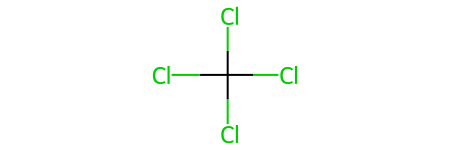

In [188]:
mol = Chem.AddHs(Chem.MolFromSmiles(sml))
mol

Next we define a `MolecularIsotope` class to store an RDKit molecule along with an abundance. (If we didn't need to store the abundance, we could simply use RDKit mol and extract the exact mass.)

In [189]:
class MolecularIsotope():
  """Store a molecule's isotopic properties."""
  def __init__(
      self,
      sml: str,
      abundance: float = None):
    self.sml = sml
    self.abundance = abundance
    try:
      self.mol = Chem.AddHs(Chem.MolFromSmiles(sml))
    except:
      self.mol = Chem.AddHs(Chem.MolFromSmiles(sml, sanitize=False))
    self.mass = Descriptors.ExactMolWt(self.mol)
    
  def update(self):
    self.mass = Descriptors.ExactMolWt(self.mol)
    self.canon_sml = Chem.MolToSmiles(mol)

Next we create a utility function to get the set of elements in a molecule.

In [190]:
def element_set(molecule):
    """Get the set of elements in an RDKit molecule
    For example, ethanol (SMILES CCO, formula C2H5OH)
    returns {'C', 'O', 'H'}.

    :param molecule: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    if molecule:
      # Add hydrogen atoms--RDKit excludes them by default
      molecule_with_Hs = Chem.AddHs(molecule)
      atom_symbols = set(atom.GetSymbol() for atom in molecule_with_Hs.GetAtoms())
      return atom_symbols

In [218]:
set_of_elements = element_set(mol)
print(set_of_elements)

{'C', 'Cl'}


Now we can create a data structure to hold the isotopic abundances of each element in our molecule. We get the abundances from the [Mendeleev](https://pypi.org/project/mendeleev/) package, filtering to those isotopes whose abundance is not `None`.

In [223]:
isotopes = {}
for element_symbol in set_of_elements:
  element_isotopes = mendeleev.element(element_symbol).isotopes
  occurring_isotopes = [[isotope.mass_number, isotope.abundance/100] for isotope in element_isotopes if isotope.abundance != None]
  isotopes[element_symbol] = occurring_isotopes
print(isotopes)

{'C': [[12, 0.9894], [13, 0.0106]], 'Cl': [[35, 0.758], [37, 0.242]]}


In [194]:
# Build iterable of number of isotopes by atom index
isotopes_by_atom_index = ()
for atom_index, atom in enumerate(mol.GetAtoms()):
  atom_symbol = atom.GetSymbol()
  isotopes_by_atom_index += (len(isotopes[atom_symbol]),)

# Create the empty numpy ndarray with the shape of the number of isotopes for each atom
mol_isotopes = np.empty(isotopes_by_atom_index, dtype=object)

## Setting the isotope of each atom in each permutation

Now we come to the key operation: Setting the isotope of each atom in a molecule, for each permutation.

To get a sense of the scale of the operation, let's calculate how many permutations (isotopologues) we'll have to assign isotopes to.

In [227]:
mol_isotopes.size

32

The `set_isotopes` function assigns isotopes to all elements in a multi-dimensional ndarray by
- recursively traversing down the ndarray until it comes to an individual element, not another (nested) ndarray
- creating the MolecularIsotope object, including its RDKit molecule
- for each atom,
    - assigning the isotope by referring to the `isotopes` array
    - assigning its abundance
    - calculating the overall abundance as the product of each of the atom's abundances
- calling the MolecularIsotope.update() method to set the exact mass

In [193]:
def set_isotopes(arr:np.ndarray, sml: str, current_index=()):
    if isinstance(arr, np.ndarray):
        for i in range(len(arr)):
            arr[i] = set_isotopes(arr=arr[i], current_index=current_index + (i,), sml=sml)
        return arr
    else:
        # For an individual item in the ndarray, create molecule, 
        # set the isotopes of each of its atoms, and calculate abundance
        item = MolecularIsotope(sml=sml)
        mol = item.mol
        abundance = 1
        for atom_index, atom in enumerate(mol.GetAtoms()):
          atom_symbol = atom.GetSymbol()
          isotope_data_to_use = isotopes[atom_symbol][current_index[atom_index]]
          isotope_to_use = isotope_data_to_use[0]
          atom.SetIsotope(isotope_to_use)
          abundance *= isotope_data_to_use[1]
        item.update()
        item.abundance = abundance          
        return item

Let's set the isotope of each atom in the molecule for each permutation.

In [226]:
# Set the isotopes for each atom in each molecule
mol_isotopes = set_isotopes(arr = mol_isotopes, sml = sml, current_index=())

Because we're creating each permutation, we'll have to aggregate the isotopomers, analogous to matching up <sup>35</sup>Cl<sup>37</sup>Cl and <sup>37</sup>Cl<sup>35</sup>Cl.

It might be tempting to match molecules by mass, but a floating-point value can have some error or uncertainty. In some cases, the mass differences between different species can be quite small (for example less than 0.002 amu if the sum of the [mass numbers](https://en.wikipedia.org/wiki/Mass_number) is the same), so adding a tolerance risks lumping different isotopologues together. So it's best to use a non-numerical identifier. In this case, we use the composition, which contains isotope labels. In particular, we
- use a nested dictionary where the first level key is the element e.g. Cl, and the second level is the isotope:count, for example 35:4 indicates that <sup>35</sup>Cl appears four times in the molecule
- convert to [JSON](https://en.wikipedia.org/wiki/JSON), sorting the keys to ensure a consistent order
- hash the result using `hash_nested_dict()`, below, to create a single string for comparison.

In [195]:
def composition(
        molecule,
        isotopes=False):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, fluoride ion (chemical formula F-, SMILES string [F-])
    returns {9: 1, 0: -1}.

    :param molecule: The molecule to analyze
    :type some_input: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    if molecule:

        # Add hydrogen atoms--RDKit excludes them by default
        Chem.AddHs(molecule)
        comp = defaultdict(lambda: 0)

        # Get atom counts
        for atom in molecule.GetAtoms():
            element_symbol = atom.GetSymbol()
            if not isotopes:
                comp[element_symbol] += 1
            else:
                isotope = atom.GetIsotope()
                try:
                    comp[element_symbol][isotope] += 1
                except:
                    comp[element_symbol] = defaultdict(lambda: 0)
                    comp[element_symbol][isotope] += 1
        return comp

To make it easier to compare isotopic variations, we'll flatten the ndarray.

In [196]:
def flatten_ndarray(arr):
    flat_list = []
    for element in arr:
        if isinstance(element, np.ndarray):
            flat_list.extend(flatten_ndarray(element))
        else:
            flat_list.append(element)
    return flat_list

In [197]:
mol_isotopes_flat = flatten_ndarray(mol_isotopes)
mol_isotopes_flat.sort(key=lambda x:x.mass)

Here's the composition dictionary for one isotopologue of our molecule:

In [200]:
composition(mol_isotopes_flat[0].mol, isotopes=True)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'Cl': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {35: 4}),
             'C': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {12: 1})})

In [198]:
def hash_nested_dict(d):
    # Convert the nested dictionary to a JSON string with sorted keys
    json_str = json.dumps(d, sort_keys=True)

    # Hash the JSON string using a cryptographic hash function (e.g., SHA-256)
    hash_obj = hashlib.sha256()
    hash_obj.update(json_str.encode())
    return hash_obj.hexdigest()

Now we prepare the data to put into a Polars dataframe. We use Polars because it's easy to aggregate based on matching a value such as composition, and very fast. We extract all properties of the MolecularIsotope, most importantly its abundance. We use `hash_nested_dict()` to prepare the string for comparison for aggregation.

In [228]:
data_dict_list = []
for mol_isotope in mol_isotopes_flat:
    data_dict = {prop: getattr(mol_isotope, prop) for prop in vars(mol_isotope).keys()}
    data_dict["mol_isotope"] = mol_isotope
    composition_dict = composition(mol_isotope.mol, isotopes=True)
    hashed_composition_dict = hash_nested_dict(composition_dict)
    data_dict["composition"] = str(hashed_composition_dict)
    data_dict_list.append(data_dict)
df = pl.DataFrame(data_dict_list)
df

sml,abundance,mol,mass,canon_sml,mol_isotope,composition
str,f64,object,f64,str,object,str
"""ClC(Cl)(Cl)Cl""",0.326624,<rdkit.Chem.rdchem.Mol object at 0x31d74d850>,151.875411,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x316216210>,"""4c6f83b9736ee8…"
"""ClC(Cl)(Cl)Cl""",0.003499,<rdkit.Chem.rdchem.Mol object at 0x315e35c40>,152.878766,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x31575ce50>,"""cdc6c3e1cafb51…"
"""ClC(Cl)(Cl)Cl""",0.104279,<rdkit.Chem.rdchem.Mol object at 0x31d74da80>,153.872461,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x168d17a10>,"""af9acd632f90c2…"
"""ClC(Cl)(Cl)Cl""",0.104279,<rdkit.Chem.rdchem.Mol object at 0x31d74d770>,153.872461,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x316214890>,"""af9acd632f90c2…"
"""ClC(Cl)(Cl)Cl""",0.104279,<rdkit.Chem.rdchem.Mol object at 0x315e35a80>,153.872461,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x3161e8050>,"""af9acd632f90c2…"
"""ClC(Cl)(Cl)Cl""",0.104279,<rdkit.Chem.rdchem.Mol object at 0x31615de00>,153.872461,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x316746450>,"""af9acd632f90c2…"
"""ClC(Cl)(Cl)Cl""",0.001117,<rdkit.Chem.rdchem.Mol object at 0x315e35cb0>,154.875815,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x31657e910>,"""5ee727e6796405…"
"""ClC(Cl)(Cl)Cl""",0.001117,<rdkit.Chem.rdchem.Mol object at 0x315e35d20>,154.875815,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x31657de90>,"""5ee727e6796405…"
"""ClC(Cl)(Cl)Cl""",0.001117,<rdkit.Chem.rdchem.Mol object at 0x315e35d90>,154.875815,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x316573750>,"""5ee727e6796405…"


There are a total of 32 permutations. The number of permutations is the product of the number of isotopes over each atom. In this case there are five atoms, each each (C or Cl) has two isotopes, so 2 * 2 * 2 * 2 * 2 = 2<sup>5</sup> = 32.

## Aggregating isotopomers

The following aggregation expressions tell Polars to sum over abundance, and take the first value for other columns (besides abundance, which we're aggregating on).

In [231]:
agg_exprs = [
    pl.sum("abundance").alias("abundance")
] + [
    pl.col(col).first().alias(col)
    for col in df.columns
    if col not in ("composition", "abundance")
]
result_df = df.group_by("composition").agg(agg_exprs)
result_df = result_df.sort("abundance", descending = True)
result_df

composition,abundance,sml,mol,mass,canon_sml,mol_isotope
str,f64,str,object,f64,str,object
"""af9acd632f90c2…",0.417114,"""ClC(Cl)(Cl)Cl""",<rdkit.Chem.rdchem.Mol object at 0x31d74da80>,153.872461,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x168d17a10>
"""4c6f83b9736ee8…",0.326624,"""ClC(Cl)(Cl)Cl""",<rdkit.Chem.rdchem.Mol object at 0x31d74d850>,151.875411,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x316216210>
"""9e5efbfce17b6a…",0.199753,"""ClC(Cl)(Cl)Cl""",<rdkit.Chem.rdchem.Mol object at 0x31d74d620>,155.869511,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x31d89ec10>
"""a4439539b7e8dc…",0.042515,"""ClC(Cl)(Cl)Cl""",<rdkit.Chem.rdchem.Mol object at 0x315e35bd0>,157.86656,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x31657e490>
"""5ee727e6796405…",0.004469,"""ClC(Cl)(Cl)Cl""",<rdkit.Chem.rdchem.Mol object at 0x315e35cb0>,154.875815,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x31657e910>
"""cdc6c3e1cafb51…",0.003499,"""ClC(Cl)(Cl)Cl""",<rdkit.Chem.rdchem.Mol object at 0x315e35c40>,152.878766,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x31575ce50>
"""c9e7ca3d90fa50…",0.003393,"""ClC(Cl)(Cl)Cl""",<rdkit.Chem.rdchem.Mol object at 0x31615e110>,159.86361,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x316754e10>
"""06dde00c495662…",0.00214,"""ClC(Cl)(Cl)Cl""",<rdkit.Chem.rdchem.Mol object at 0x315e35690>,156.872865,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x315c9a590>
"""fac3200efc9f88…",0.000455,"""ClC(Cl)(Cl)Cl""",<rdkit.Chem.rdchem.Mol object at 0x31615dd90>,158.869915,"""ClC(Cl)(Cl)Cl""",<__main__.MolecularIsotope object at 0x316746dd0>


The aggregated result has 10 distinct isotopomers (combinations) compared to 32 permutations.

## Plotting isotopic molecular structures

We next extract the results and prepare them for plotting with RDKit. Because there could be many isotopomers for a given molecule, we sorted by abundance to ensure the most abundant would be plotted--RDKit limits grid images to 50 molecules by default. If you want to display more molecules, set `maxMols` in `MolsToGridImage()`. 

In [214]:
mol_isotopes_agg_rows = result_df.rows(named=True)
mol_isotopes_agg_mols = [row["mol"] for row in mol_isotopes_agg_rows]
mol_isotopes_agg_masses = [row["mass"] for row in mol_isotopes_agg_rows]
mol_isotopes_agg_abundances = [row["abundance"] for row in mol_isotopes_agg_rows]
legends = [f"{mass:.7f}: {abundance:.3e}" for mass, abundance in zip(mol_isotopes_agg_masses, mol_isotopes_agg_abundances)]

Because we've aggregated all the isotopologues, the molecular structures below represent just one (randomly-selected) isotopologue.

#TODO make a composition-string function to print out chemical formulas, like this, and use it to print the results in a table instead of using MolsToGridImage

In [235]:
from IPython.display import Markdown

text_with_subscripts = "C<sub>2</sub>H<sub>2</sub>"
Markdown(text_with_subscripts)

C<sub>2</sub>H<sub>2</sub>

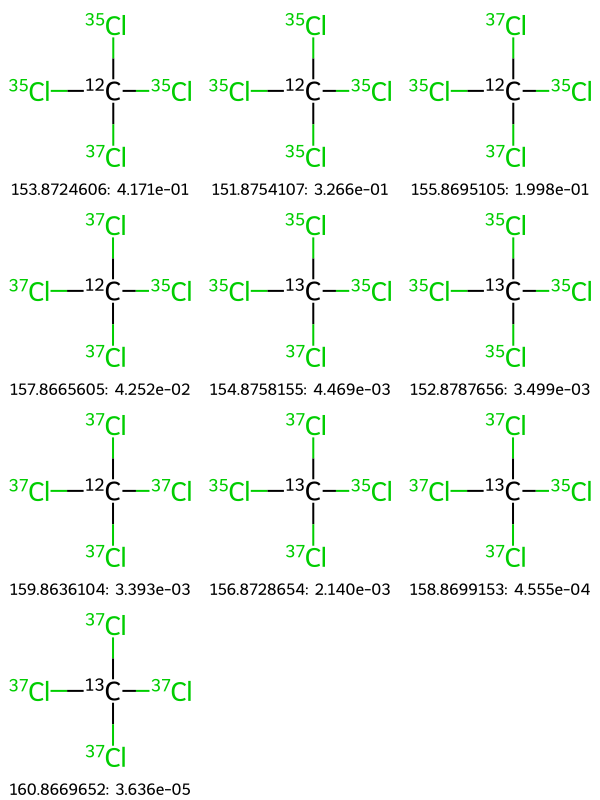

In [233]:
Chem.Draw.MolsToGridImage(mols = mol_isotopes_agg_mols, legends = legends)

To verify that we calculated and aggregated abundances correctly, we check that the sum of abundances of the isotopomers is 1. (It might be very slightly different depending on the isotope data, numerical precision of operations, etc.)

In [205]:
abundance_sum = sum(mol_isotopes_agg_abundances)
print(abundance_sum)

1.0


## Plot abundance vs. mass results

To plot the results using Seaborn as abundance against mass, we convert to a pandas dataframe

In [215]:
df_pandas_all = pd.DataFrame({
    'Mass': mol_isotopes_agg_masses,
    'Abundance': mol_isotopes_agg_abundances
})
df_pandas_all

,Mass,Abundance
0,153.872461,0.417114
1,151.875411,0.326624
2,155.869511,0.199753
3,157.866560,0.042515
4,154.875815,0.004469
5,152.878766,0.003499
6,159.863610,0.003393
7,156.872865,0.002140
8,158.869915,0.000455
9,160.866965,0.000036


There can be many isotopomers with very low abundance, so we might want to limit the plot to a cutoff level of abundance to prevent a forest of short lines and colliding labels.

In [216]:
cutoff = 0.001
df_pandas = df_pandas_all.loc[df_pandas_all['Abundance'] >= cutoff]

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


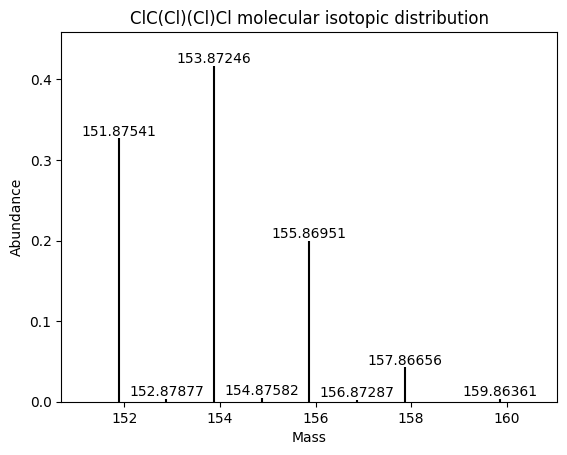

In [217]:
# Create the scatter plot using Seaborn
sns.scatterplot(x='Mass', y='Abundance', data=df_pandas, marker='')

plt.xlabel('Mass')
plt.ylabel('Abundance')
plt.title(f'{sml} molecular isotopic distribution')

# Adjust x-axis limits to allow more space on the left and right for labels
xrange = max(df_pandas['Mass']) - min(df_pandas['Mass'])
xpad = xrange * 0.15
plt.xlim(min(df_pandas['Mass']) - xpad, max(df_pandas['Mass']) + xpad)

# Adjust y-axis limits to start at zero and allow more space on the top for labels
yrange = max(df_pandas['Abundance']) - min(df_pandas['Abundance'])
ypad = yrange * 0.1
plt.ylim(0, max(df_pandas['Abundance']) + ypad)

# Add vertical lines from each data point to the x-axis
for x, y in zip(df_pandas['Mass'], df_pandas['Abundance']):
    plt.vlines(x=x, ymin=0, ymax=y, colors='black')
    # Label the data points by mass
    plt.text(x=x, y=y, s=f'{x:.5f}', ha='center', va='bottom')

plt.show()

## Conclusion

That's it for this approach. Again, creating a molecule for each permutation is computationally expensive, so in part 2 I'll share a more sophisticated and tractable approach using combinations.

*Acknowledgement: I thank my late father [Robert Monat](https://www.arnmortuary.com/obituary/Robert-Monat) for teaching me about combinations vs. permutations.*